## Graphical Voronoi variables with StructureBoost
A primary capability of StructureBoost is its handling of categorical variables that have a *structure* that is not ordinal in nature.  In this notebook, we see how even numerical variables such as coordinates may contain interesting structure.  We will demonstrate how to use the `graphical_voronoi` feature type in StructureBoost to explore and exploit this higher-dimensional structure.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
plt.style.use('classic')
%matplotlib inline
import time as time
import json
import random

from sklearn.metrics import log_loss, brier_score_loss, mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import scipy as sp

import structureboost as stb
import xgboost as xgb
import catboost as cb



## Motion Capture Data
The data from this example comes from the *MoCap Hand Postures* data set (available in the UC Irvine Repository at https://archive.ics.uci.edu/ml/datasets/MoCap+Hand+Postures).  The data set records the positions of sensors on a glove as different users make different hand gestures.  To goal is to classify which one of 5 different hand postures the user is making, based on the positions of the sensors.  The 5 possible postures are: 
- 1: Fist(with thumb out)
- 2: Stop(hand flat)
- 3: Point1(point with pointer finger)
- 4: Point2(point with pointer and middle fingers)
- 5: Grab(fingers curled as if to grab).

In this example, we use just 3 sensors and try to distiguish posture 5 (Grab) from the others.  (If desired, one can easily choose a different posture as the "target")

## Load and Process Data

In [2]:
df1 = pd.read_csv('../data/postures_3.csv')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78095 entries, 0 to 78094
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Class   78095 non-null  int64  
 1   User    78095 non-null  int64  
 2   X0      78095 non-null  float64
 3   Y0      78095 non-null  float64
 4   Z0      78095 non-null  float64
 5   X1      78095 non-null  float64
 6   Y1      78095 non-null  float64
 7   Z1      78095 non-null  float64
 8   X2      78095 non-null  float64
 9   Y2      78095 non-null  float64
 10  Z2      78095 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 6.6 MB


In [3]:
df1.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2
0,1,0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,-52.919272
1,1,0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,-69.982489
2,1,0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,-70.658489
3,1,0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,-72.228461
4,1,0,55.142401,71.435607,-64.177303,36.175818,81.556874,-53.475747,76.986143,42.426849,-72.574743


In [4]:
## These are a couple of helper functions for the demo

def get_corner_mat(data_array):
    ndim = data_array.shape[1]
    max_vec = np.zeros(ndim)
    min_vec = np.zeros(ndim)
    for i in range(ndim):
        max_vec[i] = np.max(data_array[:,i])
        min_vec[i] = np.min(data_array[:,i])
    corner_mat  = np.zeros((2**ndim,ndim))
    for i in range(2**ndim):
        base_num = i
        for j in range(ndim):
            ind_int = base_num//(2**(ndim-j-1))
            corner_mat[i,j] = max_vec[j] if ind_int else min_vec[j]
            base_num = base_num - ind_int*(2**(ndim-j-1))
    return corner_mat

def ridge_points_to_edge_set(rpl):
    return {frozenset([sublist[i],sublist[i+1]])  for sublist in rpl 
        for i in range(-1,len(sublist)-1) if (sublist[i]!=-1 and sublist[i+1]!=-1)}


## 2d view of some data points
To begin exploring the data, we will start by looking at just the X and Y coordinates of sensor 0.

In [5]:
# Sample a small number of points from each class
np.random.seed(123)
sample_size = 25
sample1 = df1[df1.Class==1].sample(sample_size)
sample2 = df1[df1.Class==2].sample(sample_size)
sample3 = df1[df1.Class==3].sample(sample_size)
sample4 = df1[df1.Class==4].sample(sample_size)
sample5 = df1[df1.Class==5].sample(sample_size)

In [6]:
# Choose two classes and assign their colors
pts_to_plot = pd.concat((sample1, sample3))
colors_to_use = np.array(list(map(lambda x: 'yellow' if x==1 else 'blue', pts_to_plot.Class)))

# Get the X and Y coordinates, and add the "corner" points -- outer limits of what we expect to see
vsm_2d = pts_to_plot.loc[:,['X0','Y0']].values
cm_2d = get_corner_mat(df1.loc[:,['X0','Y0']].values)
vsm_2d = np.vstack((vsm_2d, cm_2d))
colors_to_use_2d = np.concatenate((colors_to_use, ['black']*len(cm_2d)))

# Define x and y points
x_points = vsm_2d[:,0]
y_points = vsm_2d[:,1]

Below we see points from class 1 (in yellow) and points from class 3 (in blue).  The 4 black points in the corners represent the outer limits of what we expect to see.

We are only plotting the X and Y coordinates of one sensor (ignoring the Z direction).  However, already a pattern can be seen where the yellow points are mostly clustered together, and the blue points are in a few different areas around that.

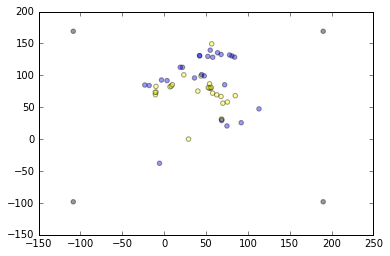

In [7]:
# First, let's just look at x and y coordinates in 2d to simplify
plt.scatter(x_points, y_points, c=colors_to_use_2d, alpha=.4)

If we were to use just the raw X and Y coordinates as features, the only splits that would be considered would be the horizonal and vertical lines on the plot above.  However, we can use the capabilities of StructureBoost to find more interesting splits on the regions.  The following will show exactly how we might do this.

First we will randomly sample, say, 8 points, in addition to keeping the corners

In [8]:
vor_sample_size = 8
rand_pts = np.random.choice(np.arange(50), size=vor_sample_size, replace=False)
rand_pts

array([ 3, 39, 35, 26,  6, 29, 21, 25])

In [9]:
chosen_pts = np.concatenate((rand_pts, np.arange(sample_size*2,sample_size*2+4)))
vsm_2d_red = vsm_2d[chosen_pts,:]
vsm_2d_red

array([[  54.01893279,   80.14708743],
       [  -3.15394392,   92.70207821],
       [  36.27690904,   95.948379  ],
       [  -5.51823138,  -37.85326256],
       [   6.99229021,   82.06365146],
       [  81.00603666,  130.44922359],
       [  75.52787844,   58.20879165],
       [  42.14430362,  131.10598182],
       [-108.55273845,  -98.23375643],
       [-108.55273845,  169.17546367],
       [ 190.01783527,  -98.23375643],
       [ 190.01783527,  169.17546367]])

Plot the 8 points together with the corners - we will call these 12 points "chosen points"

<Figure size 432x288 with 0 Axes>

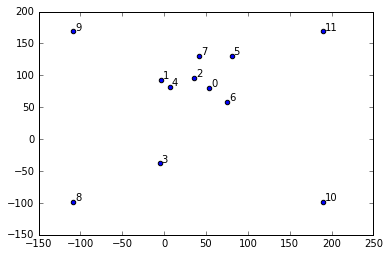

In [10]:
vor_2d = sp.spatial.Voronoi(vsm_2d_red)
fig = plt.figure()
x_pts = vsm_2d_red[:,0]
y_pts = vsm_2d_red[:,1]

    
plt.figure(figsize=(6,4))
plt.scatter(x_pts, y_pts);
i=0
for x, y in zip(x_pts, y_pts):
    label = str(i)
    i+=1
    plt.text(x+2, y+2, s=label);

Now we do a *Voronoi triangulation* - essentially we divide up the area in that square, mapping every point in the plane to the "chosen point" it is closest to.

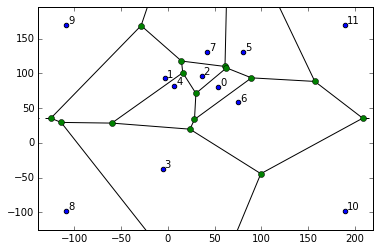

In [11]:
sp.spatial.voronoi_plot_2d(vor_2d);
plt.scatter(x_pts, y_pts);
i=0
for x, y in zip(x_pts, y_pts):
    label = str(i)
    i+=1
    plt.text(x+2, y+2, s=label);

Now, we treat each region in the plane as a *category* - in particular, by identifying each region with its "chosen point".  So every region gets labeled with its associated "chosen point".  

Ideally, some regions should be denser in blue points and others denser in yellow points.  We will see this below as we superimpose the Voronoi triangulation on our initial scatterplot.

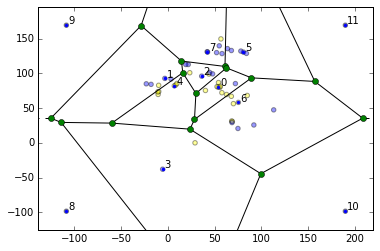

In [12]:
sp.spatial.voronoi_plot_2d(vor_2d);
plt.scatter(x_points, y_points, c=colors_to_use_2d, alpha=.4)
i=0
for x, y in zip(x_pts, y_pts):
    label = str(i)
    i+=1
    plt.text(x+2, y+2, s=label);

Now, we treat each region in the plane as a *category* - in particular, by identifying each region with its "chosen point" and putting edges between neighboring regions, we can now treat our pair of numerical coordinates (X0, Y0) as a single structured categorical variable, with a graph as shown below.  Now, when we consider "splits" on this new structured categorical variable, we can consider something like "Regions 4, 2, and 0 go left, and all other regions go right"

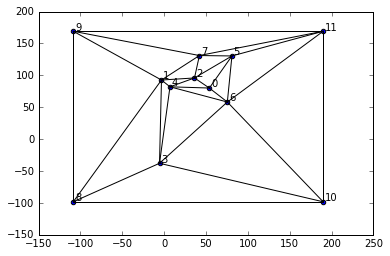

In [13]:
plt.scatter(x_pts, y_pts);
i=0
for x, y in zip(x_pts, y_pts):
    label = str(i)
    i+=1
    plt.text(x+2, y+2, s=label);
qwe = ridge_points_to_edge_set(vor_2d.ridge_points)
for fs in qwe:
    edge = np.array(list(fs))
    plt.plot(vor_2d.points[edge,0],vor_2d.points[edge,1], color='black')

At each node (of the decision tree), whenever we check splits for this variable, we resample the available points, recreate the regions and the graph, and then evaluate a set of splits as determined by the `split_method` and associated parameters.

When we go to predict on a new data point, we simply determine what region the point is in, and then send it down the appropriate branch of the tree.

## Voronoi in 3d
The approach we outlined above works for an arbitrary number of dimensions.  We showed it above in 2-dimensions for easier visualization.  Next we show how the process would look in 3-dimensions

In [14]:
vsm_3d = pts_to_plot.loc[:,['X0','Y0','Z0']].values
cm_3d = get_corner_mat(df1.loc[:,['X0','Y0','Z0']].values)
vsm_3d = np.vstack((vsm_3d, cm_3d))
colors_to_use_3d = np.concatenate((colors_to_use, ['black']*len(cm_3d)))

x_points = vsm_3d[:,0]
y_points = vsm_3d[:,1]
z_points = vsm_3d[:,2]

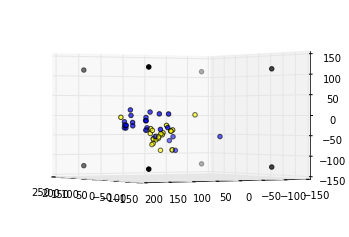

In [15]:
fig = plt.figure()
ax = plt.axes(projection="3d")

ax.scatter3D(x_points, y_points, z_points, c=colors_to_use_3d);
ax.view_init(30, 30)

# Try different views to get a sense of the 3d structure of the points
ax.view_init(0, 150)
# ax.view_init(0, 80)
# ax.view_init(-90, 60)

In [16]:
chosen_pts = np.concatenate((rand_pts, np.arange(sample_size*2,sample_size*2+8)))
vsm_3d_red = vsm_3d[chosen_pts,:]
vsm_3d_red

array([[  54.01893279,   80.14708743,  -57.75105122],
       [  -3.15394392,   92.70207821,  -34.65659414],
       [  36.27690904,   95.948379  ,    7.69060679],
       [  -5.51823138,  -37.85326256,  -52.98198392],
       [   6.99229021,   82.06365146,  -43.07396923],
       [  81.00603666,  130.44922359,  -16.24774039],
       [  75.52787844,   58.20879165,  -57.57916161],
       [  42.14430362,  131.10598182,  -17.8189266 ],
       [-108.55273845,  -98.23375643, -126.77087192],
       [-108.55273845,  -98.23375643,  113.34511874],
       [-108.55273845,  169.17546367, -126.77087192],
       [-108.55273845,  169.17546367,  113.34511874],
       [ 190.01783527,  -98.23375643, -126.77087192],
       [ 190.01783527,  -98.23375643,  113.34511874],
       [ 190.01783527,  169.17546367, -126.77087192],
       [ 190.01783527,  169.17546367,  113.34511874]])

In [17]:
vor_3d = sp.spatial.Voronoi(vsm_3d_red)
x_pts_3d = vsm_3d_red[:,0]
y_pts_3d = vsm_3d_red[:,1]
z_pts_3d = vsm_3d_red[:,2]

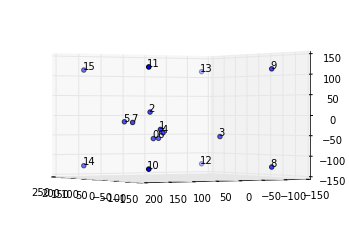

In [18]:
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter3D(x_pts_3d, y_pts_3d, z_pts_3d);
i=0
for x, y, z in zip(x_pts_3d, y_pts_3d, z_pts_3d):
    label = str(i)
    i+=1
    ax.text(x+2, y+2, z+2, label)

ax.view_init(30, 30)
ax.view_init(0, 150)


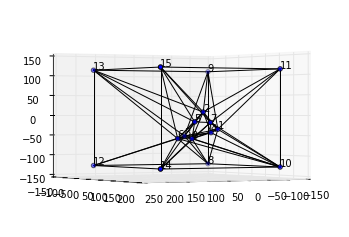

In [19]:
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter3D(x_pts_3d, y_pts_3d, z_pts_3d);
i=0
for x, y, z in zip(x_pts_3d, y_pts_3d, z_pts_3d):
    label = str(i)
    i+=1
    ax.text(x+2, y+2, z+2, label)
qwe = ridge_points_to_edge_set(vor_3d.ridge_points)
for fs in qwe:
    edge = np.array(list(fs))
    ax.plot3D(vor_3d.points[edge,0],vor_3d.points[edge,1],vor_3d.points[edge,2], c='black')

## Change numbers below to rotate plot    
#ax.view_init(30, 30)
ax.view_init(0, 60)


## Using the Graphical Voronoi feature in StructureBoost
In this next section we show how to use the `graphical_voronoi` feature type in StructureBoost in order to train models and make predictions on new cases.  We compare the performance to standard boosting packages using only the coordinates and show a remarkable improvement in performance.

In [20]:
df1.Class.value_counts()

3    16344
1    16265
5    15733
2    14978
4    14775
Name: Class, dtype: int64

In [21]:
df1.User.value_counts()

10    9573
0     9048
13    8739
11    8061
14    7495
8     6811
5     5105
12    4865
1     4717
2     4513
6     4377
9     3920
7      492
4      379
Name: User, dtype: int64

## Creating train and test sets
To avoid "leakage" we train on users 0-10, use number 11 for early stopping, and then test on users 12-14.
We use class 5 "Grab" as the positive case and the remaining postures as negative cases.

If desired, these choices can be modified by changing the next two cells

In [22]:
df_train = df1[df1.User<11]
df_valid = df1[(df1.User==11)]
df_test = df1[df1.User>=12]
df_train.shape, df_valid.shape, df_test.shape, df1.shape

((48935, 11), (8061, 11), (21099, 11), (78095, 11))

In [23]:
positive_class = 5

feature_list = ['X0','Y0','Z0','X1','Y1','Z1','X2','Y2','Z2']
X_train = df_train.loc[:,feature_list]
X_valid = df_valid.loc[:,feature_list]
X_test = df_test.loc[:,feature_list]
y_train = (df_train.Class==positive_class).astype(int)
y_valid = (df_valid.Class==positive_class).astype(int)
y_test = (df_test.Class==positive_class).astype(int)

## Configuring StructureBoost for Graphical Voronoi variables
Here we configure our StructureBoost model. We have one "feature" for each sensor.  Each feature will be created from the X,Y,Z variables of a particular sensor. Note that this breaks the usual one-to-one correspondence between "feature" and "columns" of the training data. Here a single feature (representing a sensor) depends on 3 columns of the data.

For each voronoi feature we must specify:
- **subfeature_list**: the (numerical) columns from which the feature is created
- **voronoi_sample_size**: how many points to sample to create regions (not including the corners, which are created automatically)
- **voronoi_min_pts**: how many data points there must be to attempt to split on this variable
- **split_method**: what method should I use to create splits for the resulting categorical variable
- **num_span_trees**: since I chose `span_tree` the split method, I must pass along the associated parameters for that method

In [24]:
# Create the feature_configs dictionary

my_feature_configs = {}

my_fc_sensor0 = {}
my_fc_sensor0['feature_type'] = 'graphical_voronoi'
my_fc_sensor0['subfeature_list'] = ['X0', 'Y0', 'Z0']
my_fc_sensor0['voronoi_sample_size'] = 10
my_fc_sensor0['voronoi_min_pts'] = 10
my_fc_sensor0['split_method'] = 'span_tree'
my_fc_sensor0['num_span_trees'] = 1

my_fc_sensor1 = {}
my_fc_sensor1['feature_type'] = 'graphical_voronoi'
my_fc_sensor1['subfeature_list'] = ['X1', 'Y1', 'Z1']
my_fc_sensor1['voronoi_sample_size'] = 10
my_fc_sensor1['voronoi_min_pts'] = 10
my_fc_sensor1['split_method'] = 'span_tree'
my_fc_sensor1['num_span_trees'] = 1

my_fc_sensor2 = {}
my_fc_sensor2['feature_type'] = 'graphical_voronoi'
my_fc_sensor2['subfeature_list'] = ['X2', 'Y2', 'Z2']
my_fc_sensor2['voronoi_sample_size'] = 10
my_fc_sensor2['voronoi_min_pts'] = 10
my_fc_sensor2['split_method'] = 'span_tree'
my_fc_sensor2['num_span_trees'] = 1

my_feature_configs['sensor0'] = my_fc_sensor0
my_feature_configs['sensor1'] = my_fc_sensor1
my_feature_configs['sensor2'] = my_fc_sensor2

my_feature_configs

{'sensor0': {'feature_type': 'graphical_voronoi',
  'subfeature_list': ['X0', 'Y0', 'Z0'],
  'voronoi_sample_size': 10,
  'voronoi_min_pts': 10,
  'split_method': 'span_tree',
  'num_span_trees': 1},
 'sensor1': {'feature_type': 'graphical_voronoi',
  'subfeature_list': ['X1', 'Y1', 'Z1'],
  'voronoi_sample_size': 10,
  'voronoi_min_pts': 10,
  'split_method': 'span_tree',
  'num_span_trees': 1},
 'sensor2': {'feature_type': 'graphical_voronoi',
  'subfeature_list': ['X2', 'Y2', 'Z2'],
  'voronoi_sample_size': 10,
  'voronoi_min_pts': 10,
  'split_method': 'span_tree',
  'num_span_trees': 1}}

In [25]:
## Fit the StructureBoost model, using the validation set to determine early stopping
# Takes about 10 min to run on my 2019 MacBook Pro
my_stboost = stb.StructureBoost(num_trees=2000, learning_rate=.05,
                                 feature_configs=my_feature_configs,
                                 max_depth=8, mode='classification')

my_stboost.fit(X_train, y_train, eval_set=(X_valid,y_valid), eval_freq=20, early_stop_past_steps=3)

i=0, eval_set_log_loss = 0.49848850285899493
i=20, eval_set_log_loss = 0.4149457560528687
i=40, eval_set_log_loss = 0.37268256114345455
i=60, eval_set_log_loss = 0.3472974348341809
i=80, eval_set_log_loss = 0.33414146964684677
i=100, eval_set_log_loss = 0.32232855296110985
i=120, eval_set_log_loss = 0.316383173120824
i=140, eval_set_log_loss = 0.3117757831263935
i=160, eval_set_log_loss = 0.30819503150590255
i=180, eval_set_log_loss = 0.3061457350316929
i=200, eval_set_log_loss = 0.304549457093414
i=220, eval_set_log_loss = 0.3007555699124983
i=240, eval_set_log_loss = 0.3011774101552264
i=260, eval_set_log_loss = 0.2965232809748516
i=280, eval_set_log_loss = 0.2974694732496742
i=300, eval_set_log_loss = 0.2961402764565476
i=320, eval_set_log_loss = 0.29729040428613557
Stopping early: curr_loss of 0.29729040428613557
                                        exceeds compare_loss of 0.2965232809748516


In [26]:
## Evaluate the results
answers = my_stboost.predict(X_test)
stb_log_loss_8, stb_auc_score_8 = log_loss(y_test, answers), roc_auc_score(y_test,answers)


## Comparison to CatBoost, XGBoost
In the following we compare the performance above to CatBoost and XGBoost (using just the raw coordinate values).  Since the optimal max_depth setting may be different, we try many possible values of max_depth and use the same early stopping criteria to optimize the model.
CatBoost has a maximum of 16 for max_depth.


In [27]:
md_to_check_cb = np.arange(2,17)
ll_vec_cb = np.zeros(len(md_to_check_cb))
auc_vec_cb = np.zeros(len(md_to_check_cb))
md_to_check_cb

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [28]:
for i in range(len(md_to_check_cb)):
    print('max_depth = {}'.format(md_to_check_cb[i]))
    model_cb = cb.CatBoostClassifier(iterations=2000, early_stopping_rounds=60, max_depth=md_to_check_cb[i],
                                 learning_rate=.05, loss_function='Logloss')
    model_cb.fit(X_train, y_train,  eval_set=(X_valid, y_valid), verbose=100)

    answers_cb = model_cb.predict_proba(X_test)
    ll_vec_cb[i], auc_vec_cb[i] = log_loss(y_test,answers_cb), roc_auc_score(y_test,answers_cb[:,1])

max_depth = 2
0:	learn: 0.6698511	test: 0.6728809	best: 0.6728809 (0)	total: 65ms	remaining: 2m 9s
100:	learn: 0.3607467	test: 0.4597419	best: 0.4562332 (79)	total: 836ms	remaining: 15.7s
200:	learn: 0.3019747	test: 0.4457360	best: 0.4457360 (200)	total: 1.58s	remaining: 14.2s
300:	learn: 0.2611187	test: 0.4402750	best: 0.4402750 (300)	total: 2.36s	remaining: 13.3s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.4402750448
bestIteration = 300

Shrink model to first 301 iterations.
max_depth = 3
0:	learn: 0.6645850	test: 0.6697690	best: 0.6697690 (0)	total: 6.42ms	remaining: 12.8s
100:	learn: 0.2969792	test: 0.4425786	best: 0.4425786 (100)	total: 849ms	remaining: 16s
200:	learn: 0.2277672	test: 0.4340608	best: 0.4322164 (192)	total: 1.68s	remaining: 15s
300:	learn: 0.1860745	test: 0.4282419	best: 0.4257105 (283)	total: 2.51s	remaining: 14.2s
400:	learn: 0.1589195	test: 0.4236142	best: 0.4230363 (395)	total: 3.33s	remaining: 13.3s
Stopped by overfitting detector  (60 

In [29]:
md_to_check_xgb = np.arange(2,25)
ll_vec_xgb = np.zeros(len(md_to_check_xgb))
auc_vec_xgb = np.zeros(len(md_to_check_xgb))
for i in range(len(md_to_check_xgb)):
    print('max_depth = {}'.format(md_to_check_xgb[i]))
    xgb_model = xgb.XGBClassifier(n_estimators=2000, max_depth=md_to_check_xgb[i],
                                 learning_rate=.05)
    xgb_model.fit(X_train, y_train,  eval_set=[(X_valid, y_valid)], early_stopping_rounds=60, 
                              eval_metric='logloss', verbose=False)

    answers_xgb = xgb_model.predict_proba(X_test)
    ll_vec_xgb[i], auc_vec_xgb[i] = log_loss(y_test,answers_xgb), roc_auc_score(y_test,answers_xgb[:,1])

max_depth = 2
max_depth = 3
max_depth = 4
max_depth = 5
max_depth = 6
max_depth = 7
max_depth = 8
max_depth = 9
max_depth = 10
max_depth = 11
max_depth = 12
max_depth = 13
max_depth = 14
max_depth = 15
max_depth = 16
max_depth = 17
max_depth = 18
max_depth = 19
max_depth = 20
max_depth = 21
max_depth = 22
max_depth = 23
max_depth = 24


In [30]:
cb_min_ll_md = md_to_check_cb[np.argmin(ll_vec_cb)]
xgb_min_ll_md = md_to_check_xgb[np.argmin(ll_vec_xgb)]
cb_max_auc_md = md_to_check_cb[np.argmax(auc_vec_cb)]
xgb_max_auc_md = md_to_check_xgb[np.argmax(auc_vec_xgb)]

print('Log Loss')
print('StructureBoost:  log loss = {} (at max_depth 8)'.format(np.round(stb_log_loss_8, decimals=5)))
print('CatBoost:    min log loss = {} at max_depth {}'.format(np.round(np.min(ll_vec_cb), decimals=5), cb_min_ll_md))
print('XGBoost:     min log loss = {} at max_depth {}'.format(np.round(np.min(ll_vec_xgb), decimals=5), xgb_min_ll_md))

print('\nROC AUC')
print('StructureBoost: roc auc = {} (at max_depth 8)'.format(np.round(stb_auc_score_8, decimals=5)))
print('CatBoost:   max roc auc = {} at max_depth {}'.format(np.round(np.max(auc_vec_cb), decimals=5), cb_max_auc_md))
print('XGBoost:    max roc auc = {} at max_depth {}'.format(np.round(np.max(auc_vec_xgb), decimals=5), xgb_max_auc_md))


Log Loss
StructureBoost:  log loss = 0.18474 (at max_depth 8)
CatBoost:    min log loss = 0.23329 at max_depth 16
XGBoost:     min log loss = 0.32349 at max_depth 18

ROC AUC
StructureBoost: roc auc = 0.96582 (at max_depth 8)
CatBoost:   max roc auc = 0.95001 at max_depth 16
XGBoost:    max roc auc = 0.89611 at max_depth 18
